# Error with different subsets of genes

In [1]:
import scape
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)

scape.__version__

'0.1.0'

In [2]:
df_de = scape.io.load_slogpvals("_data/de_train.parquet")
df_lfc = scape.io.load_lfc("_data/lfc_train.parquet")

# Make sure rows/columns are in the same order
df_lfc = df_lfc.loc[df_de.index, df_de.columns]
df_de.shape, df_lfc.shape

((614, 18211), (614, 18211))

In [3]:
def create_model(n_genes):
    # Data sources point to the dataframes with the data from which the features are extracted
    data_sources = {
        'slogpval': df_de,
        'lfc_pseudo': df_lfc
    }

    # Define the way in which the features are extracted from the data sources
    feature_extraction = {
        'slogpval_drug': {
            'source': 'slogpval',
            'groupby': 'sm_name',
            'function': 'median'
        },
        'lfc_drug': {
            'source': 'lfc_pseudo',
            'groupby': 'sm_name',
            'function': 'median'
        },
        'slogpval_cell': {
            'source': 'slogpval',
            'groupby': 'cell_type',
            'function': 'median'
        },
        'lfc_cell': {
            'source': 'lfc_pseudo',
            'groupby': 'cell_type',
            'function': 'median'
        }
    }

    # Names of the input layers -> feature extraction method
    input_mapping = {
        'in_slogpval_drug': 'slogpval_drug',
        'in_lfc_drug': 'lfc_drug',
        'in_slogpval_cell_encoder': 'slogpval_cell',
        'in_lfc_cell_encoder': 'lfc_cell',
        'in_slogpval_cell_decoder': 'slogpval_cell',
        'in_lfc_cell_decoder': 'lfc_cell',
    }

    # Configuration for the NN architecture
    config = {
        "inputs": {
            "in_slogpval_drug"          : [n_genes, 256, 128],
            "in_lfc_drug"               : [n_genes, 256, 128],
        },
        "conditional_encoder_input_structure": {
            "in_slogpval_cell_encoder"  : [n_genes, 32],
            "in_lfc_cell_encoder"       : [n_genes, 32, 16],
        },
        "conditional_decoder_input_structure": {
            "in_slogpval_cell_decoder"  : [n_genes, 32],
            "in_lfc_cell_decoder"       : [n_genes, 32, 16],
        },
        "conditional_decoder_input_hidden_sizes": [32],
        "encoder_hidden_layer_sizes": [128, 128],
        "decoder_hidden_layer_sizes": [128, 512],
        "outputs": {
            "logpval": (df_de.shape[1], "linear"), 
        },
        # Layer config
        "noise": 0.01,
        "dropout": 0.05,
        "l1": 0,
        "l2": 0
    }

    model_setup = {
        "data_sources": data_sources,
        "feature_extraction": feature_extraction,
        "input_mapping": input_mapping,
        "output_genes": df_de.columns,
        "config": config
    }

    # Create model
    return scape.SCAPE(model_setup)

In [4]:
# Get NK cells
drugs = df_de[df_de.index.get_level_values("cell_type") == "NK cells"].index.get_level_values("sm_name").unique()
# Select a subset of 30 drugs randomly with np sample
drugs = np.random.choice(drugs, 30, replace=False).tolist()
drugs

['Isoniazid',
 'Penfluridol',
 'Ixabepilone',
 'Canertinib',
 'CGP 60474',
 'SCH-58261',
 'RG7112',
 'Tivantinib',
 'RVX-208',
 'Lapatinib',
 'Trametinib',
 'Defactinib',
 'CGM-097',
 'UNII-BXU45ZH6LI',
 'Imatinib',
 'LDN 193189',
 'GSK256066',
 'Clemastine',
 'MK-5108',
 'Porcn Inhibitor III',
 'Sunitinib',
 'BAY 87-2243',
 'Selumetinib',
 'GO-6976',
 'Resminostat',
 'STK219801',
 'Amiodarone',
 'FK 866',
 'Nilotinib',
 'Flutamide']

In [21]:
results_s = {}
for n_genes in [1, 2, 4, 8, 16, 32, 64, 128, 256]:
    print(f"N. genes: {n_genes}")
    top_genes = scape.util.select_top_variable([df_de], k=n_genes)
    scm = create_model(n_genes)
    result = scm.train(
        val_cells=["NK cells"], 
        val_drugs=drugs,
        input_columns=top_genes,
        epochs=300,
        baselines=["zero", "slogpval_drug"]
    )
    results_s[n_genes] = result

N. genes: 1
Baseline zero MRRMSE: 1.3112
Baseline slogpval_drug MRRMSE: 1.1747
Model size (MB): 36.60
Model inputs: ['in_slogpval_drug', 'in_lfc_drug', 'in_slogpval_cell_encoder', 'in_lfc_cell_encoder', 'in_slogpval_cell_decoder', 'in_lfc_cell_decoder']
Epoch    1: val_loss None -> 1.3091, train loss: 1.3065 (lr=0.00500)
	 > Improvement factor/percentage zero                 (err=1.3112): 1.0016, 0.16%
	 > Improvement factor/percentage slogpval_drug        (err=1.1747): 0.8973, -11.44%
Epoch    2: val_loss 1.3091 -> 1.3058, train loss: 1.2823 (lr=0.00500)
	 > Improvement factor/percentage zero                 (err=1.3112): 1.0041, 0.41%
	 > Improvement factor/percentage slogpval_drug        (err=1.1747): 0.8996, -11.16%
Epoch    3: val_loss 1.3058 -> 1.2960, train loss: 1.2613 (lr=0.00500)
	 > Improvement factor/percentage zero                 (err=1.3112): 1.0117, 1.16%
	 > Improvement factor/percentage slogpval_drug        (err=1.1747): 0.9064, -10.32%
Epoch    4: val_loss 1.2960 -> 

<Axes: xlabel='n_genes'>

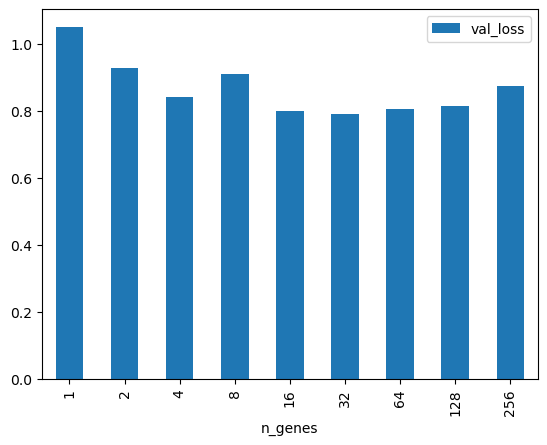

In [22]:
errors = []
for k, v in results_s.items():
    errors.append((k, v['history'].val_loss.min()))
pd.DataFrame(errors, columns=["n_genes", "val_loss"]).set_index("n_genes").plot.bar()

In [5]:
results = {}
for n_genes in [32, 64, 128, 256, 512, 1024, 2048, 4096, 8192, 16384]:
    print(f"N. genes: {n_genes}")
    top_genes = scape.util.select_top_variable([df_de], k=n_genes)
    scm = create_model(n_genes)
    result = scm.train(
        val_cells=["NK cells"], 
        val_drugs=drugs,
        input_columns=top_genes,
        epochs=300,
        baselines=["zero", "slogpval_drug"]
    )
    results[n_genes] = result

N. genes: 32

Baseline zero MRRMSE: 1.3112
Baseline slogpval_drug MRRMSE: 1.1747
Model size (MB): 36.68
Model inputs: ['in_slogpval_drug', 'in_lfc_drug', 'in_slogpval_cell_encoder', 'in_lfc_cell_encoder', 'in_slogpval_cell_decoder', 'in_lfc_cell_decoder']

Epoch    1: val_loss None -> 1.3045, train loss: 1.3058 (lr=0.00500)
	 > Improvement factor/percentage zero                 (err=1.3112): 1.0051, 0.51%
	 > Improvement factor/percentage slogpval_drug        (err=1.1747): 0.9005, -11.05%
Epoch    2: val_loss 1.3045 -> 1.2678, train loss: 1.2771 (lr=0.00500)
	 > Improvement factor/percentage zero                 (err=1.3112): 1.0342, 3.30%
	 > Improvement factor/percentage slogpval_drug        (err=1.1747): 0.9266, -7.93%
Epoch    3: val_loss 1.2678 -> 1.2447, train loss: 1.2554 (lr=0.00500)
	 > Improvement factor/percentage zero                 (err=1.3112): 1.0533, 5.06%
	 > Improvement factor/percentage slogpval_drug        (err=1.1747): 0.9437, -5.96%
Epoch    5: val_loss 1.2447 ->

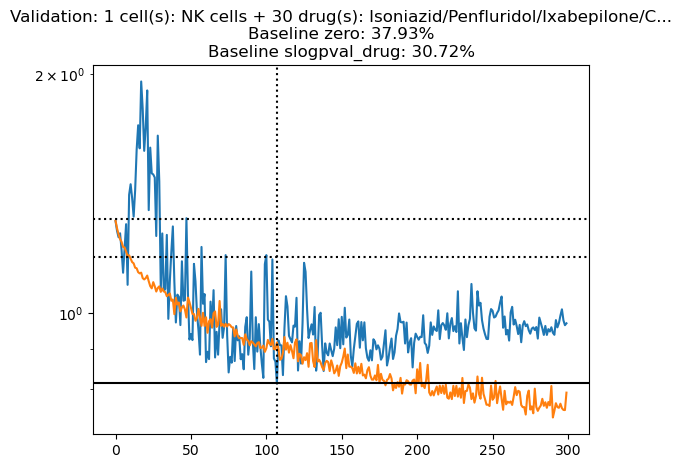

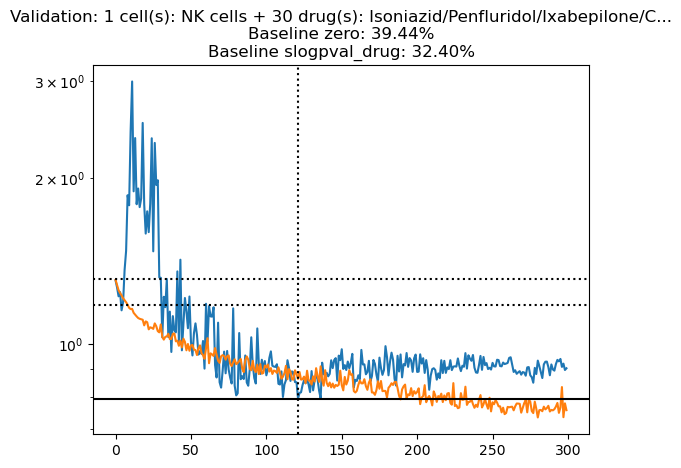

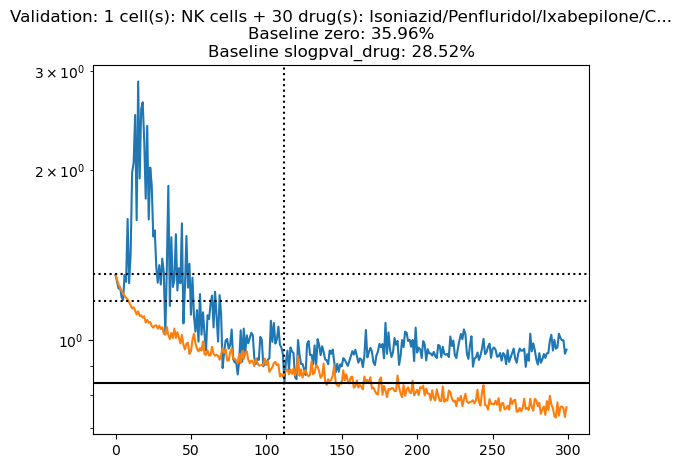

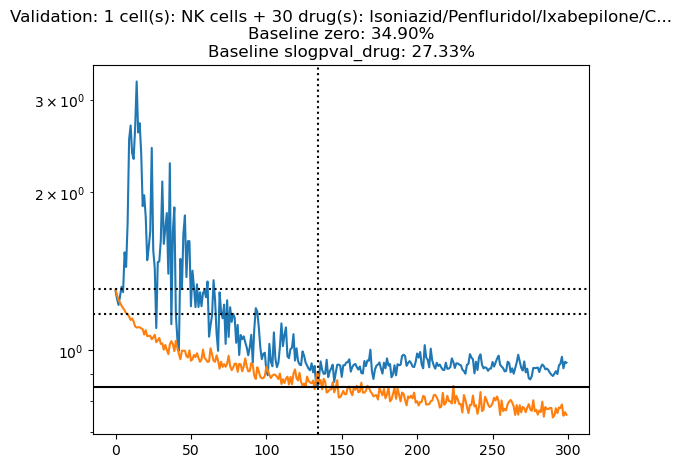

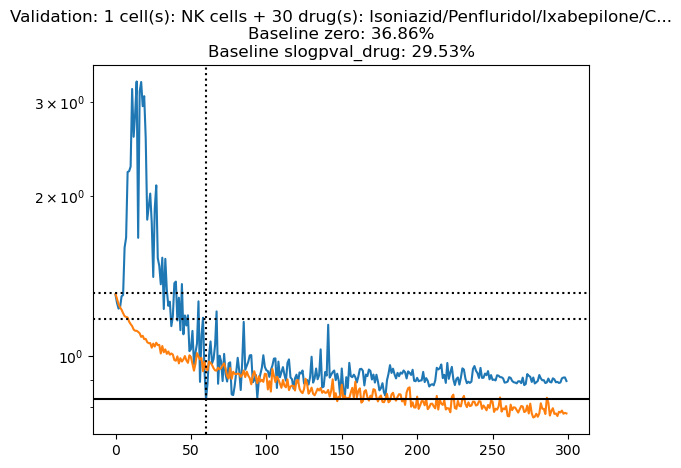

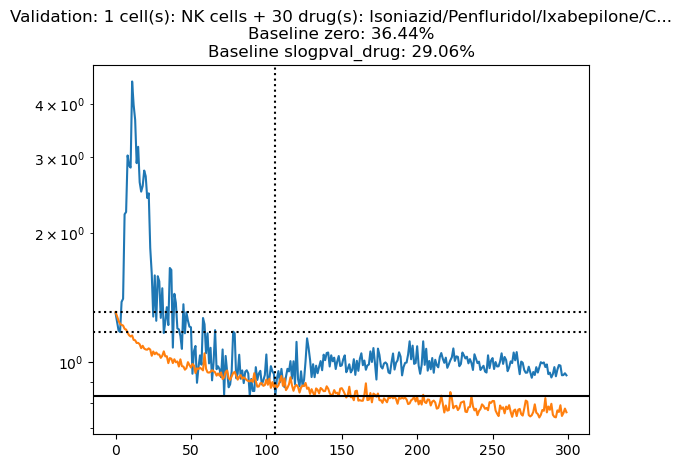

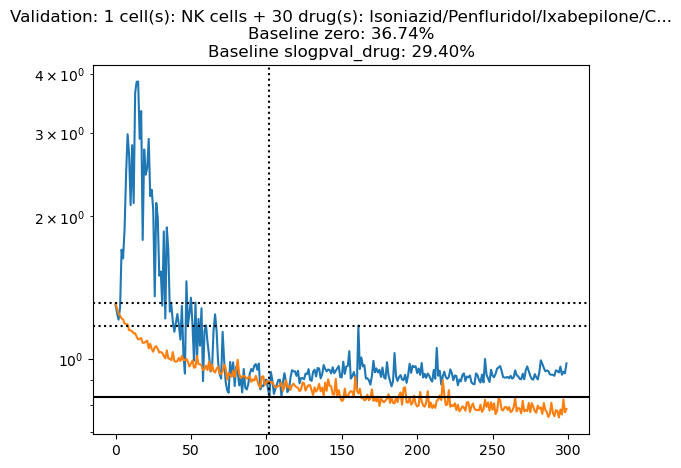

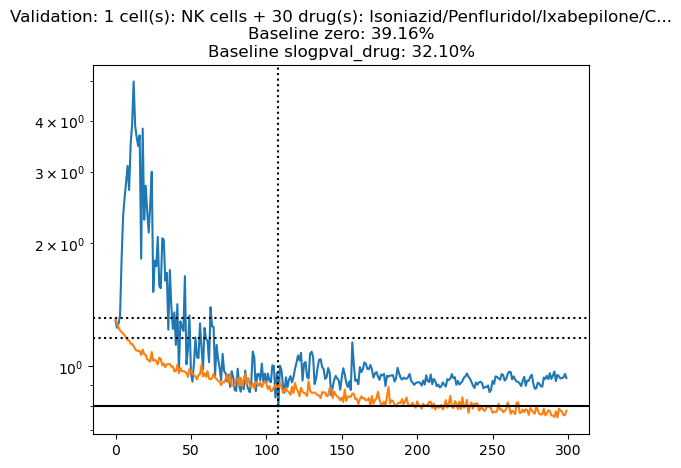

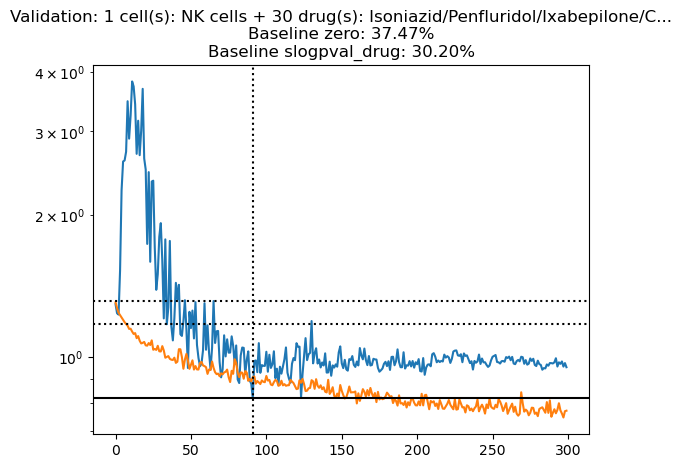

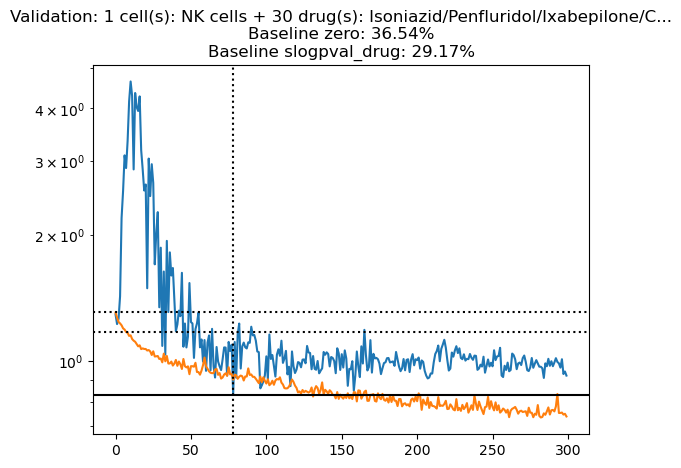

In [6]:
for k, v in results.items():
    scape.util.plot_result(v)

<Axes: xlabel='n_genes'>

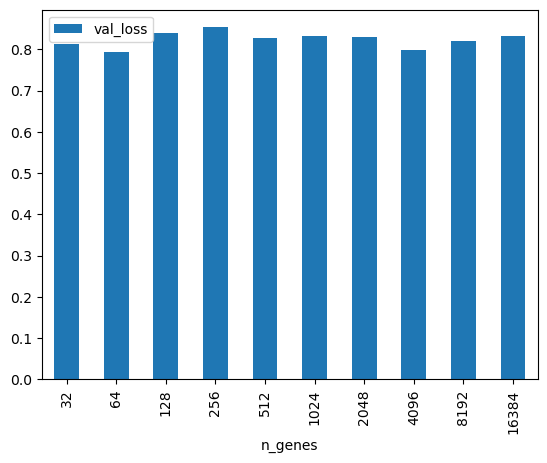

In [19]:
errors = []
for k, v in results.items():
    errors.append((k, v['history'].val_loss.min()))
pd.DataFrame(errors, columns=["n_genes", "val_loss"]).set_index("n_genes").plot.bar()